<a href="https://colab.research.google.com/github/jmatrone/EnvDatSci/blob/main/CodeSprints/ObservationDependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Additional packages required in Google Collaboratory:
!pip install pysal
!pip install libpysal
!pip insall geopandas

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.4/347.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.

<div align="center">
<h2 style="text-align: center;">Moran's I for diagnosing spatial autocorrelation in model residuals.

In this example, we calculate a global Moran's I statistic to evaluate spatial autocorrelation in a dataset containing county-level results from the 2012 and 2016 presidential elections and US census data. We will then attempt to fit a linear regression predicting change in 2012-2016 voting patterns using two spatial covariates (county level per-capita income, and land area). We will evaluate the OLS linear regression residuals for spatial autocorrealtion,  then reevalute model fit using an autoregressive model.





In [3]:
import pysal as ps
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights.contiguity import Queen
import libpysal
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran_Local
from esda.moran import Moran
from statsmodels.api import OLS
from pysal.model import spreg
import urllib.request
import shutil
from mlxtend.preprocessing import standardize
sns.set_style('white')

First, we're going to open 'Elections' dataset from the Geodata Center at the University of Chicago.

* More on spatial data science resources from UC: https://spatial.uchicago.edu/
* A list of datasets available through lipysal: https://geodacenter.github.io/data-and-lab//



In [4]:
#define online filepath (aka url):
url='https://geodacenter.github.io/data-and-lab//data/election.zip'

#define local filepath:
local = '/elections.zip'

#download elections data:
urllib.request.urlretrieve(url, local)

#unzip file
shutil.unpack_archive(local, '../../../')

votes = gpd.read_file('/election/election.shp')

In [5]:
print(votes.columns)

Index(['STATEFP', 'COUNTYFP', 'GEOID', 'ALAND', 'AWATER', 'area_name',
       'state_abbr', 'PST045214', 'PST040210', 'PST120214', 'POP010210',
       'AGE135214', 'AGE295214', 'AGE775214', 'SEX255214', 'RHI125214',
       'RHI225214', 'RHI325214', 'RHI425214', 'RHI525214', 'RHI625214',
       'RHI725214', 'RHI825214', 'POP715213', 'POP645213', 'POP815213',
       'EDU635213', 'EDU685213', 'VET605213', 'LFE305213', 'HSG010214',
       'HSG445213', 'HSG096213', 'HSG495213', 'HSD410213', 'HSD310213',
       'INC910213', 'INC110213', 'PVY020213', 'BZA010213', 'BZA110213',
       'BZA115213', 'NES010213', 'SBO001207', 'SBO315207', 'SBO115207',
       'SBO215207', 'SBO515207', 'SBO415207', 'SBO015207', 'MAN450207',
       'WTN220207', 'RTN130207', 'RTN131207', 'AFN120207', 'BPS030214',
       'LND110210', 'POP060210', 'Demvotes16', 'GOPvotes16', 'total_2016',
       'pct_dem_16', 'pct_gop_16', 'diff_2016', 'pct_pt_16', 'total_2012',
       'Demvotes12', 'GOPvotes12', 'county_fip', 'state_fi

<Axes: >

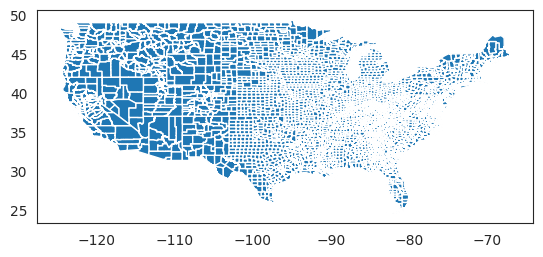

In [6]:
#Let's view the shapefile to get a general idea of the geometry we're looking at:
%matplotlib inline
votes.plot()

In [7]:
#View the first few line]s of the dataset
votes.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,total_2012,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry
0,01,005,01005,2.291821e+09,50864677.0,Barbour County,AL,26887.0,27457.0,-2.1,...,11459.0,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.748 31.619, -85.745 31.619, -85...."
1,01,023,01023,2.365955e+09,19059247.0,Choctaw County,AL,13323.0,13858.0,-3.9,...,7965.0,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.473 31.894, -88.469 31.93, -88.4..."
2,01,035,01035,2.201896e+09,6643480.0,Conecuh County,AL,12670.0,13228.0,-4.2,...,7013.0,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.427 31.264, -87.426 31.268, -87...."
3,01,051,01051,1.601877e+09,99850740.0,Elmore County,AL,80977.0,79296.0,2.1,...,35440.0,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.413 32.751, -86.371 32.751, -86...."
4,01,065,01065,1.667805e+09,32525874.0,Hale County,AL,15184.0,15760.0,-3.7,...,8628.0,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.87 32.762, -87.868 32.766, -87.8..."


The goal of our model is to predict a change in county-level voting trends between the 2012 and 2016 US presidential elections. First, we created a new column indicating the percent change in democratic vote. Then, we plotted the percent democratic vote in 2012, the percent democratic vote in 2016, and the percent change in democratic vote as maps and using global histograms.

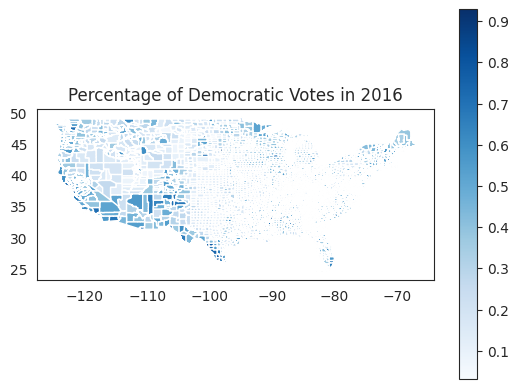

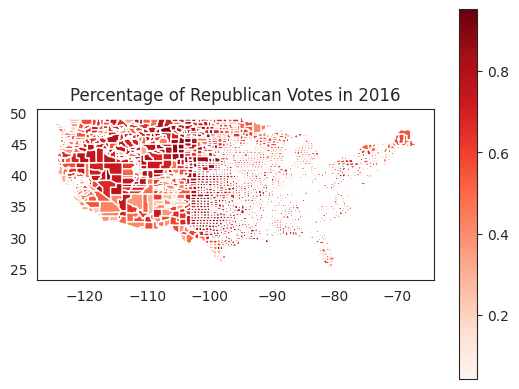

In [8]:
#To plot the difference between voter parties across the USA

import matplotlib.pyplot as plt

#Plot the percentage of Democratic votes in 2016
votes.plot(column='pct_dem_16', legend=True, cmap='Blues')
plt.title('Percentage of Democratic Votes in 2016')
plt.show()

#Plot the percentage of Republican votes in 2016
votes.plot(column='pct_gop_16', legend=True, cmap='Reds')
plt.title('Percentage of Republican Votes in 2016')
plt.show()


<ipython-input-9-849b6a06a716>:11: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
<ipython-input-9-849b6a06a716>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
<ipython-input-9-849b6a06a716>:11: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
<ipython-input-9-849b6a06a716>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; p

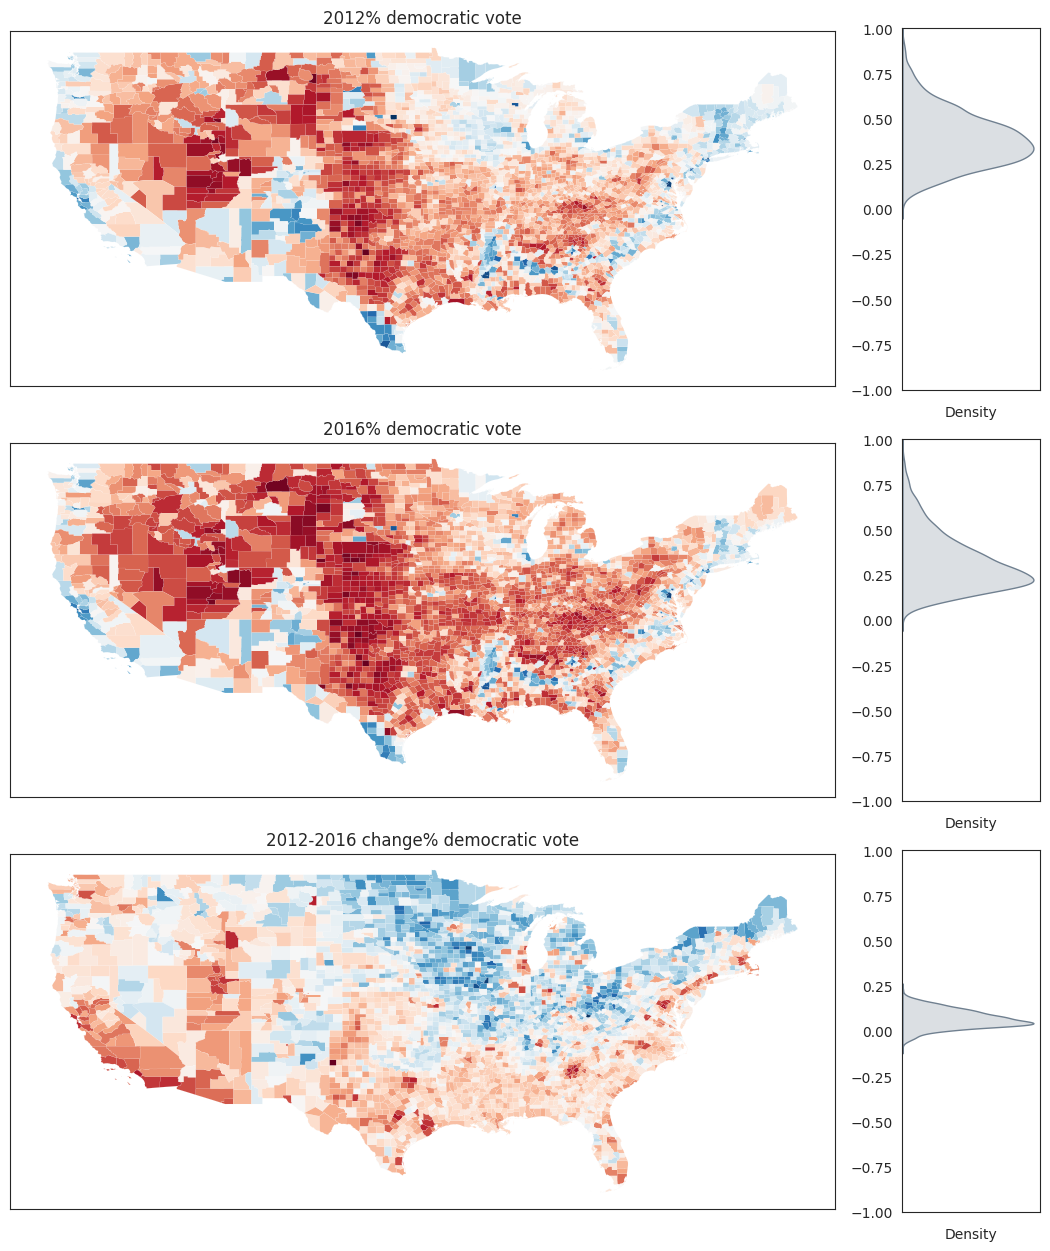

In [9]:
# Add new column pct_dem_change to votes 2012-2016
votes['pct_dem_change'] = votes['pct_dem_12'] - votes['pct_dem_16']

#visualize the Democratic vote percentages and their changes between 2012 and 2016
f,ax = plt.subplots(3,2, figsize=(1.6*6 + 1,4.2*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16', 'pct_dem_change']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    ax[i,0].set_title(['2012','2016', '2012-2016 change'][i] + "% democratic vote")
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

#density plot shows most areas experienced similar changes in the percentage of
#Democratic votes, with less variability

### Spatial Autocorrelation
From https://www.sciencedirect.com/topics/computer-science/spatial-autocorrelation

>"Spatial autocorrelation is the term used to describe the presence of *systematic* spatial variation in a variable and positive spatial autocorrelation, which is most often encountered in practical situations, is the tendency for areas or sites that are close together to have similar values."

##**Task 1: Is there evidence for *spatial autocorrelation* in the three plots above? Explain why or why not.**

I think there is evidence for spatial autocorrelation bc you have similar colors clustered together. political prefernces that are geographically concentrated. best to calculate morans i

## Was the county wide percent change in democratic vote related to per capita income?
The next question is how can we use robust statistics to determine whether per capita income or the county land area were related to a change in 2016 voting preferences. To do this, we're going to conduct a linear regression relating our parameters pct_dem_change to INC910213 and ALAND. Then, we're going to use the confidence interval around beta hat (our slope parameter estimate) to determine whether the relationships between INC910213, ALAND, and pct_dem_change are significantly different than zero.

First we're going to visualize how these variables relate in the global data:

In [10]:
votes.dropna(subset=['pct_dem_12','pct_dem_16'], inplace=True)

0.9464235104255706
-0.24471033010257184
-0.08312272316914267
-0.014495571366592337


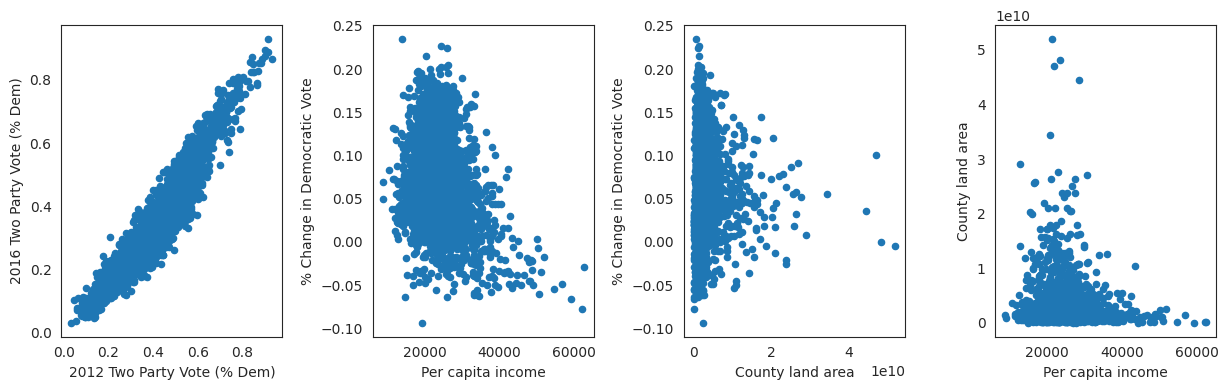

In [11]:
#4 subplots arranged in a single row
f,ax = plt.subplots(1,4, figsize=(4*3.1,4))

#comparing the percentage of Democratic votes in 2012 and 2016
votes[['pct_dem_12','pct_dem_16']].plot.scatter('pct_dem_12','pct_dem_16', ax=ax[0])
ax[0].set_xlabel('2012 Two Party Vote (% Dem)')
ax[0].set_ylabel('2016 Two Party Vote (% Dem)')
print(np.corrcoef(votes['pct_dem_12'].values, votes['pct_dem_16'].values)[0,1])
#strong positive correlation

#comparing per capita income and the percentage change in Democratic votes
votes[['INC910213','pct_dem_change']].plot.scatter('INC910213','pct_dem_change', ax=ax[1])
ax[1].set_xlabel('Per capita income')
ax[1].set_ylabel('% Change in Democratic Vote')
print(np.corrcoef(votes['pct_dem_change'].values, votes['INC910213'].values)[0,1])


#comparing county land area and the percentage change in Democratic votes
votes[['ALAND','pct_dem_change']].plot.scatter('ALAND','pct_dem_change', ax=ax[2])
ax[2].set_xlabel('County land area')
ax[2].set_ylabel('% Change in Democratic Vote')
print(np.corrcoef(votes['pct_dem_change'].values, votes['ALAND'].values)[0,1])

#per capita income and county land area
votes[['INC910213','ALAND']].plot.scatter('INC910213','ALAND', ax=ax[3])
ax[3].set_xlabel('Per capita income')
ax[3].set_ylabel('County land area')
print(np.corrcoef(votes['INC910213'].values, votes['ALAND'].values)[0,1])

#fit nicely in the plot area
f.tight_layout()
plt.show()

The first scatterplot compares the 2012 percent democratic vote to the 2016 percent democratic vote. The second two plots compare our predictor (2012-2016 % democractic vote, or pct_dem_change) to our two predictor variables (per capita income and county land area). In the fourth plot, we compare our two predictors (per capita income to county land area). We want to establish a trendline in the fourth plot using linear regression, and determine of the slope in that trendline is statistically significant.

###Theret are some features of this data that make it poorly suited for linear regression:

We are told above that we are going to be regressing the 2012-2016 change in percent democratic vote against per capita income and land area. The conditions that we need to meet for linear regression to be applicable are:
1. Linear relationship: *it appears that the relationship is approximately inverse linear, though a linear fit might not be perfect*
2. Multivariate normality: *this might be an issue...the variance in percent change democratic vote appears to increase as a function of decreasing income. This might mean that the residuals are non-normal*
3. No or little multicollinearity: *The correlation coefficient between our two predictors (per capita income and county land area) is below 0.7. For the purposes of this example, paramters have been selected that do not exhibit collinearity. Note: this does not mean the parameters are *independent*, just that the are not linearly related.*
4. No auto-correlation: *We will evaluate this later*
5. Homoscedasticity: *We will evaluate this later*


## Do we have spatial autocorrelation in our data?
When we're looking at distributions of voting preferences, remember that we're aggregating these numbers over arbitrary (er...political) geographic regions.

Each column in that dataframe represents a data value summarized over a US county, but US counties have widely different land areas and populations:

<ipython-input-12-e08615b96d9f>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['ALAND'].values, shade=True, color='slategrey', ax=ax[0])
<ipython-input-12-e08615b96d9f>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['PST045214'].values, shade=True, color='slategrey', ax=ax[1])


Text(0.5, 0, '2014 County Population')

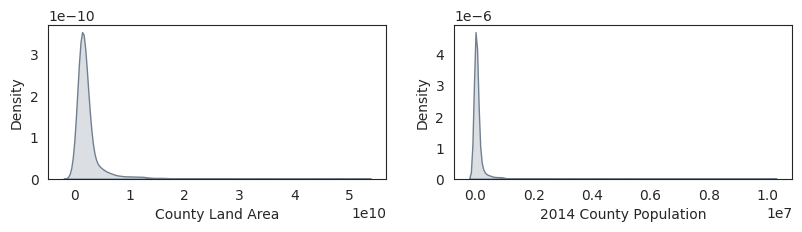

In [12]:
# two subplots aranged in a row
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
#represents county land area
sns.kdeplot(votes['ALAND'].values, shade=True, color='slategrey', ax=ax[0])
ax[0].set_xlabel('County Land Area')
#narrow peak-most counties have small land areas

#represents the 2014 county population
sns.kdeplot(votes['PST045214'].values, shade=True, color='slategrey', ax=ax[1])
ax[1].set_xlabel('2014 County Population')
#large number of counties are not heavily populated

Our *spatial sampling rate* (by county) may not accurately represent the spatial frequency of variability in voting preferences and/or income.

First, let's focus on the spatial componnet: the fact that these counties are different sizes.

If we want to identify spatial autocorrelation in our data, we need to first understand how this spatial autocorrelation decays as a function of distance.

To do this, we calculate the Moran's I statistic, which you can think of as the "slope" that we'd get when we regress data values for all geographic entities with data values that neighbor within a given distance. Lets look at our data in lat/lon space again:

In [13]:
#giving us information about the Coordinate Reference System (CRS) for the votes DataFrame
votes.crs

<Projected CRS: PROJCS["Equidistant_Cylindrical",GEOGCS["WGS 84",D ...>
Name: Equidistant_Cylindrical
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Equidistant Cylindrical
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### The horizontal unit (unit of distance) in our votes data is meters.

One issue is that we're sampling spatially at a distinct, and heterogenous, granulatiry. The smallest unit of measurement available in our dataset is the county level. Counties are different sizes. How can we evaluate whether this spatial sampling granularity is of sufficient resolution to capture the scale of variability in our dataset?

* If we are sampling at too course of a spatial scale, we run the risk of missing key patterns of variability in our data (**UNDERSAMPLING**)

* If we are sampling at too fine of a sptial scale, we run the risk of violating assumptions of independence between our individual observations (**OVERSAMPLING**)

The county spatial unit represents a method for discretizing population-level opinions. Some counties may contain communities with very different voting patterns, which we won't be able to resolve with the data (undersampling). Especailly in rural areas, some counties may represent very few people, and could therefore represent an incidence of oversampling.

## Calculating a weights matrix:
The first thing we want to tackle is a quantification of any spatial autocorrelation in our dataset. Spatial autocorrelation inflates our theoretical number of samples (N), artificially increasing the power in our test statistics. In other words, when we're calculating test statistics, spatial autocorrelation in our data can make it seem like parameters that are unimportant are actually significant.

Since we're dealing with a heterogeneous sampling grid in our data, the first thing we want to do is calculate a weights matrix.

We're going to use the Queen function in pysal to do this. Full documentation here: https://pysal.org/libpysal/generated/libpysal.weights.Queen.html

Or just use the built in help with the function below:

<ipython-input-14-21f02cf9b93e>:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(votes)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 1267, 2729, 2763.
  W.__init__(self, neighbors, ids=ids, **kw)


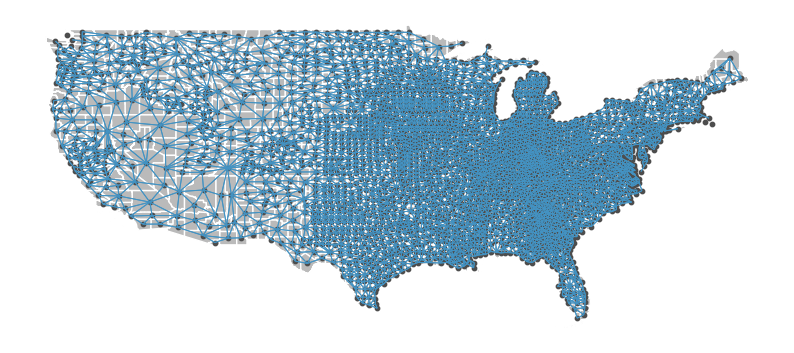

In [14]:
#Calculate weights object
weights = Queen.from_dataframe(votes)

#Use built in plot function to visualize how the weights matrix works
plot_spatial_weights(weights, votes)
plt.show()

The verticies in this plot represent two things:
* First, they link "neigbors" based on the model parameters we set for defining neighborhood (here we use the defaul settings and consider any contiguous polygons).
* The length of the verticies indicates the distance between the centers of neighborhing cells.

"Neighbors" that are father matter less than "neighbors" that are closer in identifying the strength of spatial autocorrelation.

## Calculate Moran's I:
Moran's I statistic quantifies the spatial autocorrelation in your data. From https://en.wikipedia.org/wiki/Moran%27s_I
>"Spatial dependency leads to the spatial autocorrelation problem in statistics since, like temporal autocorrelation, this violates standard statistical techniques that assume independence among observations. For example, regression analyses that do not compensate for spatial dependency can have unstable parameter estimates and yield unreliable significance tests. Spatial regression models (see below) capture these relationships and do not suffer from these weaknesses. It is also appropriate to view spatial dependency as a source of information rather than something to be corrected."

('WARNING: ', 1267, ' is an island (no neighbors)')
('WARNING: ', 2729, ' is an island (no neighbors)')
('WARNING: ', 2763, ' is an island (no neighbors)')


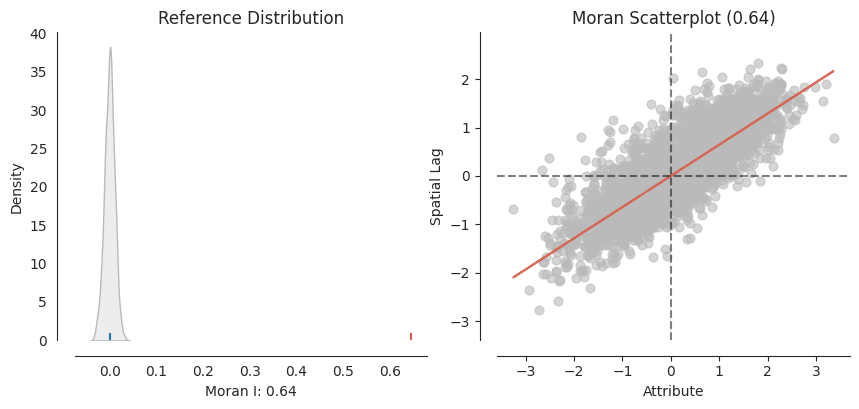

In [15]:
# calculate Moran and plot
#percentage change in Democratic votes
moran_votes = Moran(votes['pct_dem_change'], w=weights)
plot_moran(moran_votes, zstandard=True, figsize=(10,4))
plt.show()

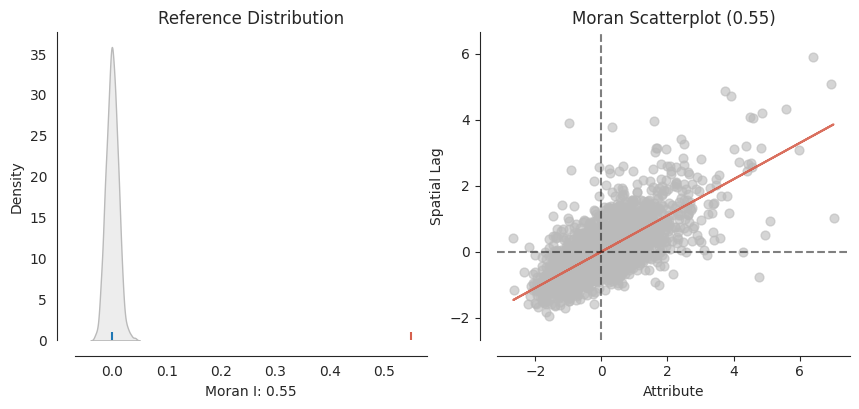

In [16]:
# calculate Moran and plot
#income data
moran_income = Moran(votes['INC910213'], w=weights)
plot_moran(moran_income, zstandard=True, figsize=(10,4))
plt.show()

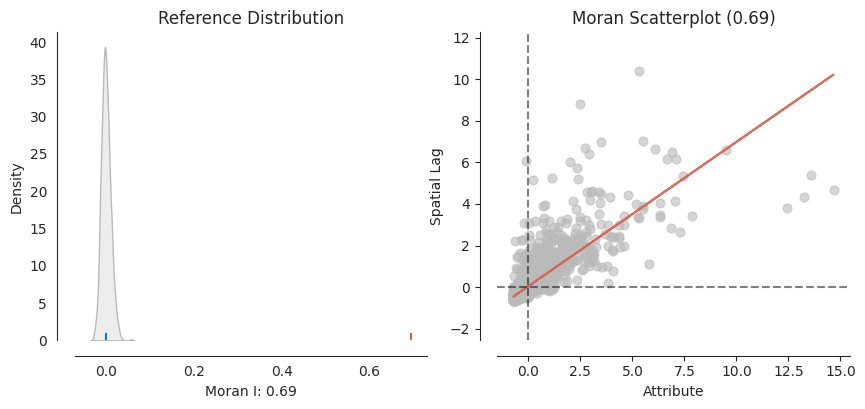

In [17]:
# calculate Moran and plot
#land area
moran_land = Moran(votes['ALAND'], w=weights)
plot_moran(moran_land, zstandard=True, figsize=(10,4))
plt.show()

In [18]:
print(moran_votes.p_norm)
print(moran_income.p_norm)
print(moran_land.p_norm)
#0.0 output - p-values are extremely small meaning
#spatial patterns in votes, income, and land area are not likely due to random chance


0.0
0.0
0.0


##Task 2: what do the p_norm values tell us? What hypothesis is being tested, what is the null hypothesis, and do we accept or reject the null hypothesis?
We reject the null hypothesis that states there is no spatail autocorrelation. Our data shows that the spaital patterns are not likely due to random chance.

## Task 3: is there autocorrelation in the data? If so, which features exhibit autocorrelation? YEs there is autocorrelation in the data and the low pvalues mean that the three we tested feature autocorrlation-votes, land, income

## Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether that analysis determines a statistically significant relationship between our percent income and percent change in democratic vote.

In [19]:
#first, forumalate the model.
#isolate and standardize the preditors:
X_raw = np.array(votes[['INC910213', 'ALAND']].values)
X = standardize(X_raw, columns=[0, 1])


#isolate and standardize predictand:
Y = np.array(votes['pct_dem_change'].values)
Y= standardize(Y)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [20]:
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.067
Model:                            OLS   Adj. R-squared (uncentered):              0.067
Method:                 Least Squares   F-statistic:                              112.2
Date:                Fri, 15 Nov 2024   Prob (F-statistic):                    8.70e-48
Time:                        16:13:34   Log-Likelihood:                         -4301.6
No. Observations:                3108   AIC:                                      8607.
Df Residuals:                    3106   BIC:                                      8619.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


With p-values of effectively zero, we can reject the null hypothesis that btoh the coefficient on INC910213 (x2) and ALAND (x2) are zero, and conclude that there is a statistically significant relationship. Increasing income and increasing land area are both associated with a statistically significant decrease in percent democratic vote. It is notable that the standard error on the standardized coefficient for both variables are nearly an order of magnitude smaller than the coefficient itself

Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values

In [21]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=lm.fit().resid

Remember, in OLS regression we depend out our residuals being normally distributed:

<ipython-input-22-c63e0edb43c7>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


Text(0.5, 24.0, 'OLS residuals')

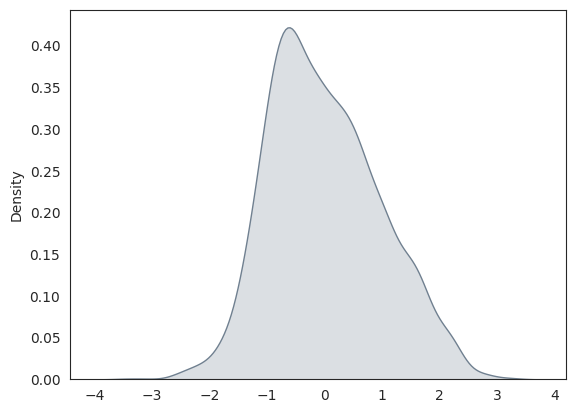

In [22]:
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('OLS residuals')

<Axes: >

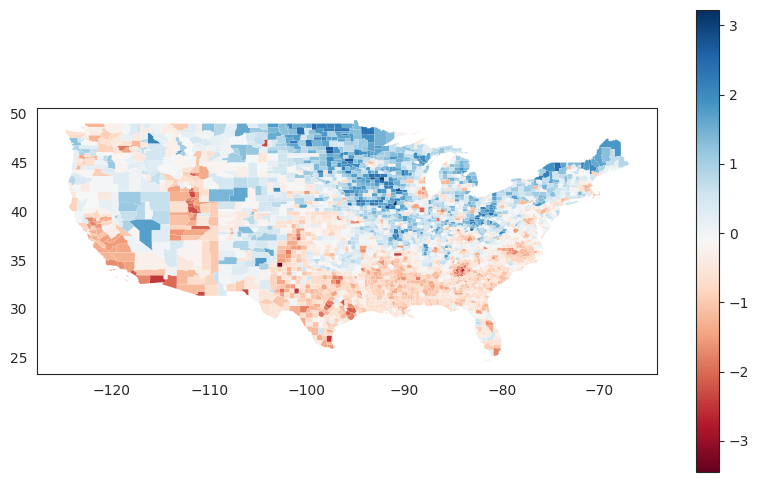

In [23]:
#Plot them in space:
#plot residuals from OLS regression model on a map
f, ax1 = plt.subplots(figsize=(10, 6))
votes.plot('lm_resid', ax=ax1, linewidth=.05, cmap='RdBu',legend = True)

These are very not normal residuals. What's going on?

## Task 5: What does a positive residual mean here (the model overpredicted change in democratic vote, the model underpredicted change in democratic vote)?



In [ ]:
#perhaps there are local variations that it doesn’t fully capture?
#That the model underpredicted the change in democratic vote percentage

With spatial data, we also care about spatial autocorrelation of our *residuals*:

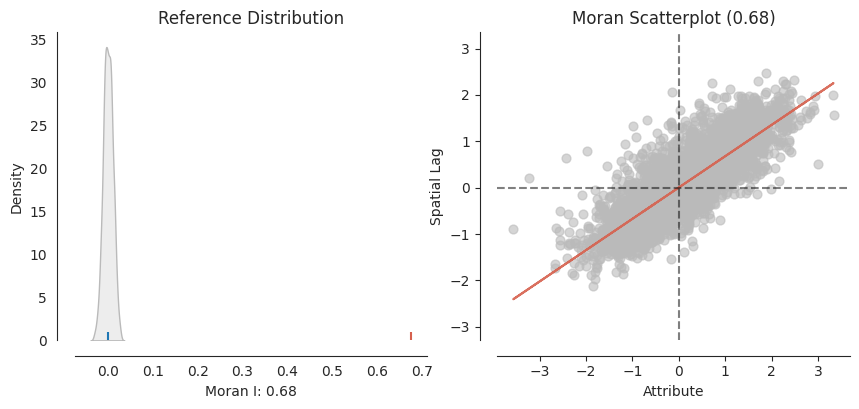

In [24]:
# calculate Moran and plot
#scatter plot to visualize the spatial autocorrelation of the residuals
moran = Moran(votes['lm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()
#we see Positive Spatial Autocorrelation
#This means that areas where the model underpredicted (positive residuals) or
#overpredicted (negative residuals) tend to be near each other
#Red Dash Outside Grey Space: Significant spatial autocorrelation in the residuals

In [25]:
moran.p_norm
#0.0 returned means-spatial autocorrelation in your residuals is highly significant

0.0

## Task 6: Do we have spatially autocorrelated residuals? Provide numbers to back your claim. Why do we care?
0.0. This extremely small p-value indicates that the spatial autocorrelation is highly significant. It suggests that the model may be missing important spatial variables or relationships. This can lead to biased or inefficient estimates

Text(0, 0.5, 'linear model residuals')

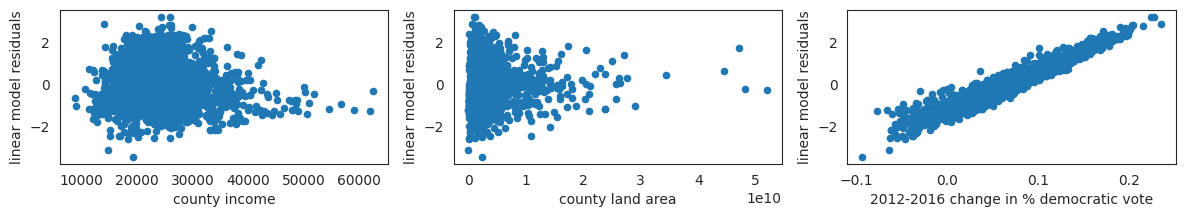

In [26]:
f,ax = plt.subplots(1,3, figsize=(3*3*1.6, 2))

votes[['INC910213','lm_resid']].plot.scatter('INC910213','lm_resid', ax=ax[0])
ax[0].set_xlabel('county income')
ax[0].set_ylabel('linear model residuals')

votes[['ALAND','lm_resid']].plot.scatter('ALAND','lm_resid', ax=ax[1])
ax[1].set_xlabel('county land area')
ax[1].set_ylabel('linear model residuals')

votes[['pct_dem_change','lm_resid']].plot.scatter('pct_dem_change','lm_resid', ax=ax[2])
ax[2].set_xlabel('2012-2016 change in % democratic vote')
ax[2].set_ylabel('linear model residuals')


*The first two plots show heteroskedasticity in our residuals. The second plot shows bias in our model*


## Autocovariate regression: spatial lag model
Let's see if we can get different answers by accounting for our residuals in our model. First, we'll try a spatial lag model. A spatial lag model is a type of autocovariate model that assumes that dependencies exist directly among the levels of the dependent variable, and models them as an "autocovariate". So we create an autocovariate function that describes the degree to which the percent change in democratic vote at one location is affected by the percent change in democratic vote at the nearby locations. The coefficient and p-value for the autocovariate function are interpreted as for the independent variables.

In [27]:
?spreg.ML_Lag

In [28]:
Yl = Y.T
Yl.shape = (len(Y),1)

lag=spreg.ML_Lag(Yl, X, weights, name_x=["income", "area"],name_y="vote", name_w="weights")
print(lag.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     weights
Dependent Variable  :        vote                Number of Observations:        3108
Mean dependent var  :     -0.0000                Number of Variables   :           4
S.D. dependent var  :      1.0002                Degrees of Freedom    :        3104
Pseudo R-squared    :      0.6739
Spatial Pseudo R-squared:  0.0119
Log likelihood      :  -3005.5395
Sigma-square ML     :      0.3409                Akaike info criterion :    6019.079
S.E of regression   :      0.5838                Schwarz criterion     :    6043.246

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

<ipython-input-29-7297fc133f9a>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['slm_resid'].values, shade=True, color='slategrey')


Text(0.5, 24.0, 'SLM residuals')

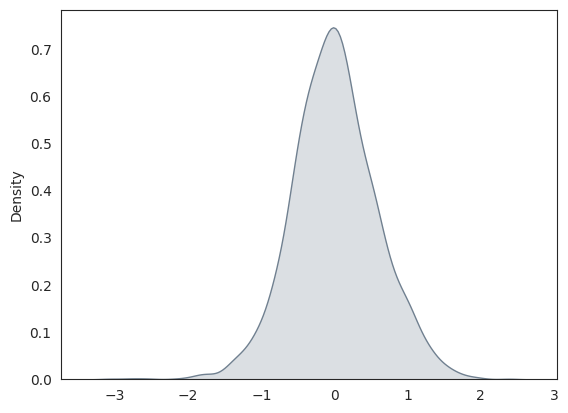

In [29]:
#Add model residuals to our "votes" geopandas dataframe:
votes['slm_resid']=lag.u
sns.kdeplot(votes['slm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('SLM residuals')

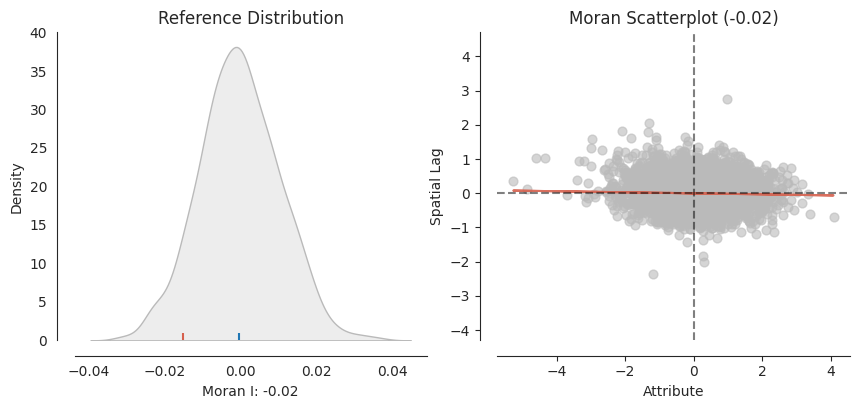

In [30]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

<Axes: >

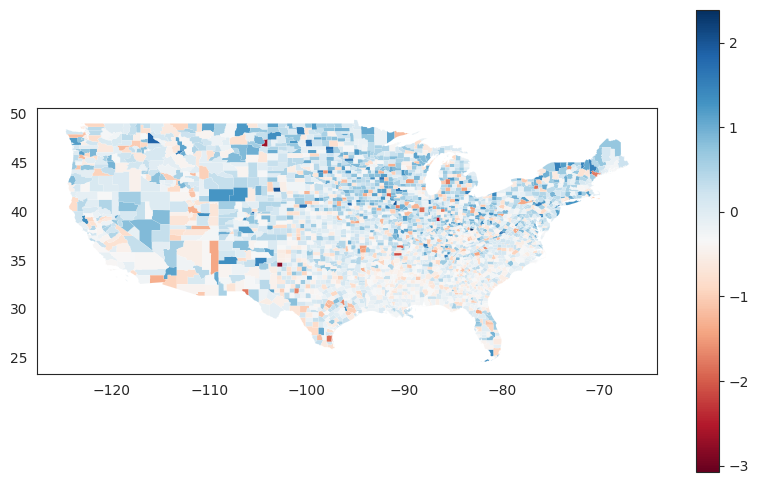

In [31]:
#Plot them in space:
f, ax1 = plt.subplots(figsize=(10, 6))
votes.plot('slm_resid', ax=ax1, linewidth=.05, cmap='RdBu',legend = True)

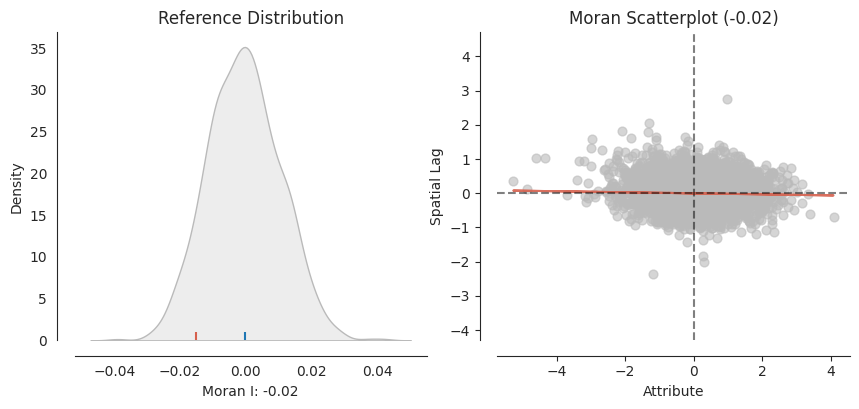

In [32]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [33]:
moran.p_norm

0.1674404941357961

Text(0, 0.5, 'spatial lag model residuals')

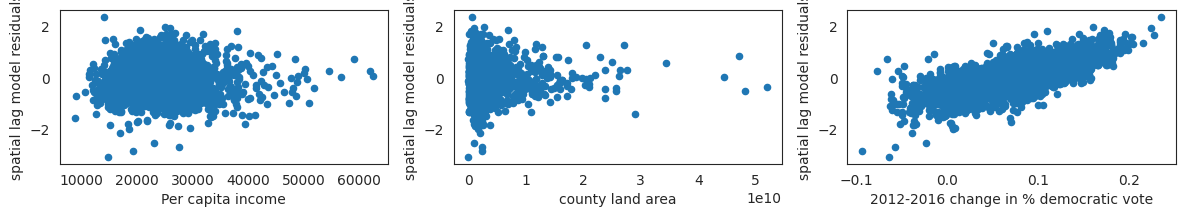

In [34]:
f,ax = plt.subplots(1,3, figsize=(3*3*1.6, 2))

votes[['INC910213','slm_resid']].plot.scatter('INC910213','slm_resid', ax=ax[0])
ax[0].set_xlabel('Per capita income')
ax[0].set_ylabel('spatial lag model residuals')

votes[['ALAND','slm_resid']].plot.scatter('ALAND','slm_resid', ax=ax[1])
ax[1].set_xlabel('county land area')
ax[1].set_ylabel('spatial lag model residuals')

votes[['pct_dem_change','slm_resid']].plot.scatter('pct_dem_change','slm_resid', ax=ax[2])
ax[2].set_xlabel('2012-2016 change in % democratic vote')
ax[2].set_ylabel('spatial lag model residuals')

## Task 7: When we account for spatial autocorrelation in our data using the spatial lag model, do we still see a significant relationship between our response and predictor variable?

Yes. the relationship between income and the change in Democratic vote percentage remains significant. However, the relationship between land area and the change in Democratic vote percentage is not significant.



## Task 8: Compare these two models. Do you believe that there is a linear relationship between percent change in democratic vote and income level? What about between change in democratic vote and land area? Explain your interpretation using model parameters and outputs.



Linear relationship with incomoe and democratic vote bc of the pvalue of 0.0. The non significant pvalue ( 0.15718) in the democratic votes and land area says not linear relationship there.